In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lars, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

# Functions

In [2]:
def outliers(df):
    descriptive_stats = df.describe(percentiles=[0.01, 0.99])
    higher_99 = []
    lower_01 = []
    
    # Identificar columnas con valores mayores al percentil 99 o menores al percentil 01
    for col in df.columns:
        max_val = descriptive_stats.loc['max', col]
        percentile_99 = descriptive_stats.loc['99%', col]
        min_val = descriptive_stats.loc['min', col]
        percentile_01 = descriptive_stats.loc['1%', col]
    
        if max_val > 2 * percentile_99:
            higher_99.append(col)
    
        if min_val < percentile_01 / 2:
            lower_01.append(col)
    
    print("Variables cuyo máximo es mayor al doble del percentil 99:", higher_99)
    print("Variables cuyo mínimo es menor a la mitad del percentil 01:", lower_01)
    
    # Filtrar filas con valores atípicos
    for col in higher_99:
        threshold = descriptive_stats.loc['99%', col]
        df = df[df[col] <= threshold]
    
    for col in lower_01:
        threshold = descriptive_stats.loc['1%', col]
        df = df[df[col] >= threshold]
    
    return df

In [82]:
def getScores(X, y, hype=False):
    dc_scores = dict()
    
    if hype:
        # Define hyperparameter grids for each model
        param_grids = {
            'LinearRegression': {},
            'Lars': {},
            'Ridge': {'alpha': np.arange(0, 1001, 10)},
            'Lasso': {'alpha': np.arange(0, 1001, 10)},
            'ElasticNet': {'alpha': [0.1, 0.5, 1.0], 'l1_ratio': [0.1, 0.5, 0.99]},
            'BayesianRidge': {}
        }
        models = {
            'LinearRegression': LinearRegression(),
            'Lars': Lars(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'ElasticNet': ElasticNet(),
            'BayesianRidge': BayesianRidge()
        }

        # Perform GridSearchCV for each model
        for name, model in models.items():
            if param_grids[name]:
                grid_search = GridSearchCV(model, param_grids[name], cv=4, scoring='r2', n_jobs=-1)
                grid_search.fit(X, y)
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
                print(f"Best parameters for {name}: {best_params}")
                ls_res = cross_val_score(estimator=best_model, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
            else:
                model.fit(X, y)
                ls_res = cross_val_score(estimator=model, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
            dc_scores.update({name: np.mean(ls_res)})
    else:
        linreg = LinearRegression(fit_intercept=True)
        linreg.fit(X, y)
        ls_res = cross_val_score(estimator=linreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(linreg).split("(")[0]: np.mean(ls_res)})

        larsreg = Lars()
        larsreg = larsreg.fit(X, y)
        ls_res = cross_val_score(estimator=larsreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(larsreg).split("(")[0]: np.mean(ls_res)})

        ridgereg = Ridge()
        ridgereg.fit(X, y)
        ls_res = cross_val_score(estimator=ridgereg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(ridgereg).split("(")[0]: np.mean(ls_res)})

        lassreg = Lasso()
        lassreg.fit(X, y)
        ls_res = cross_val_score(estimator=lassreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(lassreg).split("(")[0]: np.mean(ls_res)})

        elasnet = ElasticNet(alpha=0.5, l1_ratio=0.99)
        elasnet.fit(X, y)
        ls_res = cross_val_score(estimator=elasnet, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(elasnet).split("(")[0]: np.mean(ls_res)})

        bayreg = BayesianRidge()
        bayreg.fit(X, y)
        ls_res = cross_val_score(estimator=bayreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(bayreg).split("(")[0]: np.mean(ls_res)})

    return dc_scores

# Data

In [3]:
dirty_df = pd.read_csv('house_price_prediction.csv')

In [4]:
dirty_df.head()

,avg_income,avg_area_house_age,avg_area_num_rooms,avg_bedrooms,avg_population,price,address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


# Data Engineering

In [5]:
dirty_df['price'] = dirty_df['price'].apply(lambda x: f"{x:.6f}")

In [6]:
def get_state(address):
    if isinstance(address, str):
        match = re.search(r',\s([A-Z]{2})\s\d{5}|FPO\s([A-Z]{2})\s\d{5}|APO\s([A-Z]{2})\s\d{5}|DPO\s([A-Z]{2})\s\d{5}', address)
        if match:
            for group in match.groups():
                if group:
                    return group
    return None

In [7]:
dirty_df['state'] = dirty_df['address'].apply(get_state)

In [8]:
dirty_df.drop(columns=['address'], inplace=True)

In [9]:
num_cols = ['avg_income', 'avg_area_house_age', 'avg_area_num_rooms',
       'avg_bedrooms', 'avg_population', 'price']

In [10]:
dirty_df.head()

,avg_income,avg_area_house_age,avg_area_num_rooms,avg_bedrooms,avg_population,price,state
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1059033.558000,NE
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915000,CA
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1058987.988000,WI
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1260616.807000,AP
4,59982.19723,5.040555,7.839388,4.23,26354.10947,630943.489300,AE


# Data Cleaning

In [11]:
dirty_df.dtypes

avg_income            float64
avg_area_house_age    float64
avg_area_num_rooms    float64
avg_bedrooms          float64
avg_population        float64
price                  object
state                  object
dtype: object

In [12]:
dirty_df['price'] = dirty_df['price'].astype(float)

## Nan Values

In [13]:
dirty_df.isna().sum()

avg_income            3
avg_area_house_age    2
avg_area_num_rooms    1
avg_bedrooms          0
avg_population        3
price                 0
state                 1
dtype: int64

In [14]:
dirty_df[dirty_df['state'].isna()]

,avg_income,avg_area_house_age,avg_area_num_rooms,avg_bedrooms,avg_population,price,state
5003,74102.19189,5.657841,7.683993,3.13,NaN,1263720.518,None


In [15]:
dirty_df.dropna(subset=['state'], inplace=True)

In [16]:
assert dirty_df['state'].notna().all(), "La columna 'state' contiene valores NaN"
encoder = OneHotEncoder(drop='first', sparse=False)
state_encoded = encoder.fit_transform(dirty_df[['state']])
state_encoded_df = pd.DataFrame(state_encoded, columns=encoder.get_feature_names_out(['state']))
state_encoded_df.index = dirty_df.index
df_without_state = dirty_df.drop(columns=['state'])
dirty_df = pd.concat([df_without_state, state_encoded_df], axis=1)

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
imputador = SimpleImputer(strategy='mean')
nan_cols = ['avg_income','avg_area_house_age','avg_area_num_rooms','avg_population']
dirty_df[nan_cols] = imputador.fit_transform(dirty_df[nan_cols])

In [18]:
dirty_df.isna().sum()

avg_income            0
avg_area_house_age    0
avg_area_num_rooms    0
avg_bedrooms          0
avg_population        0
                     ..
state_VT              0
state_WA              0
state_WI              0
state_WV              0
state_WY              0
Length: 67, dtype: int64

## Outliers

In [19]:
dirty_df[num_cols].describe(percentiles=[0.01, 0.02, 0.05, 0.50, 0.95, 0.98, 0.99])

,avg_income,avg_area_house_age,avg_area_num_rooms,avg_bedrooms,avg_population,price
count,5011.000000,5011.000000,5011.000000,5011.000000,5011.000000,5.011000e+03
mean,68576.701826,5.977572,6.987767,3.982265,36155.832559,1.231941e+06
std,10658.619191,0.991363,1.006405,1.234009,9926.841464,3.529875e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
1%,43558.201684,3.649158,4.621395,2.020000,13984.828246,4.052506e+05
2%,46174.810060,3.972095,4.879576,2.050000,15785.403516,5.090612e+05
5%,50758.260780,4.326444,5.329794,2.150000,19901.500065,6.500814e+05
50%,68805.020730,5.969905,7.002940,4.050000,36179.405770,1.232974e+06
95%,86248.584055,7.610448,8.609807,6.290000,52687.638045,1.813002e+06
98%,90117.932816,8.046974,9.024734,6.420000,57157.809956,1.943216e+06


In [20]:
dirty_df.isna().sum()

avg_income            0
avg_area_house_age    0
avg_area_num_rooms    0
avg_bedrooms          0
avg_population        0
                     ..
state_VT              0
state_WA              0
state_WI              0
state_WV              0
state_WY              0
Length: 67, dtype: int64

In [21]:
clean_df = outliers(dirty_df[num_cols])
dirty_df = dirty_df.loc[clean_df.index]

Variables cuyo máximo es mayor al doble del percentil 99: []
Variables cuyo mínimo es menor a la mitad del percentil 01: ['avg_income', 'avg_population', 'price']


# EDA

In [22]:
df = dirty_df.copy()

C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

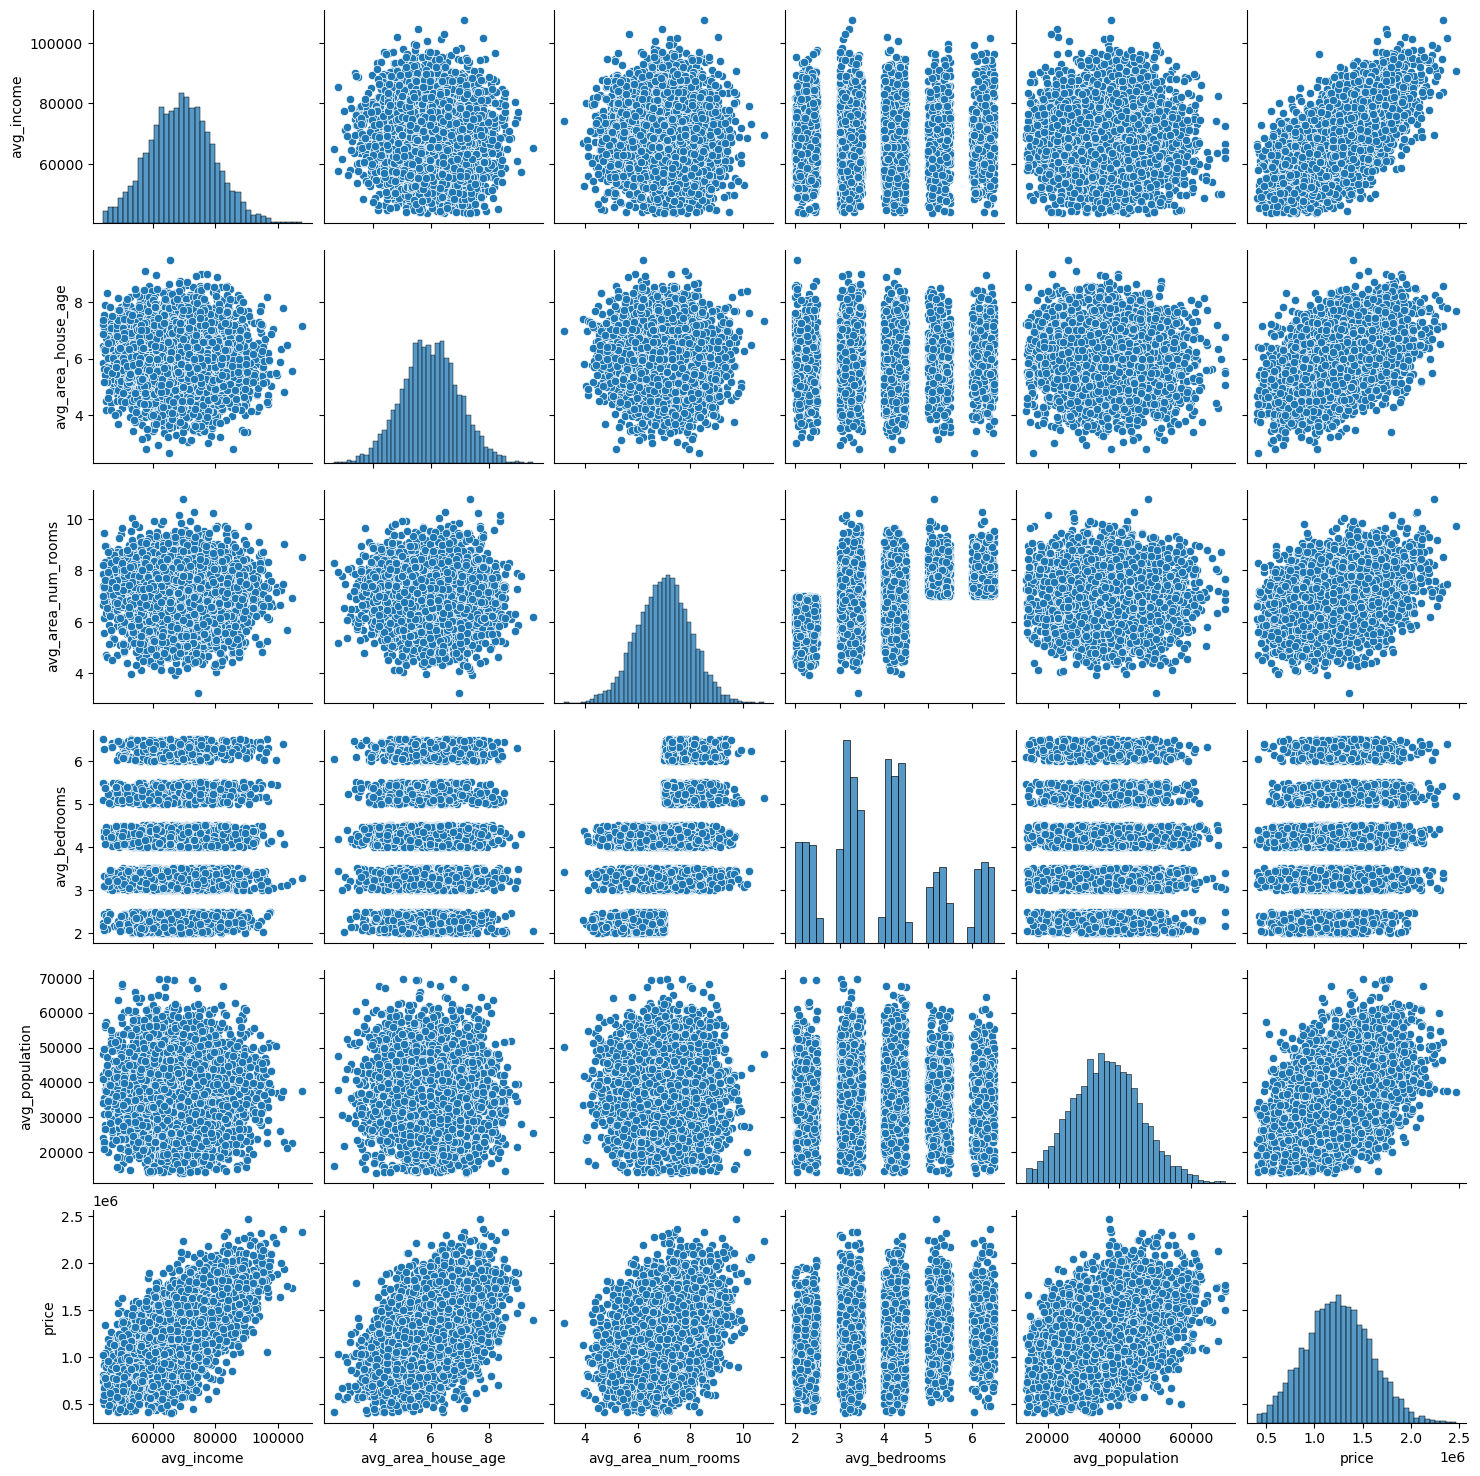

In [23]:
sns.pairplot(df[num_cols])

# Model

In [52]:
num_cols = [col for col in num_cols if col != 'price']
y = df['price'].apply(lambda x: f"{x:.6f}")

In [25]:
df.isna().sum()

avg_income            0
avg_area_house_age    0
avg_area_num_rooms    0
avg_bedrooms          0
avg_population        0
                     ..
state_VT              0
state_WA              0
state_WI              0
state_WV              0
state_WY              0
Length: 67, dtype: int64

In [37]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

In [69]:
cat_cols = df.drop(columns=num_cols)
X = pd.concat([X, cat_cols], axis=1)
X.drop(columns=['price'], inplace=True)

In [70]:
X.head()

,avg_income,avg_area_house_age,avg_area_num_rooms,avg_bedrooms,avg_population,state_AE,state_AK,state_AL,state_AP,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_FM,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MH,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_PW,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_AE,state_AK,state_AL,state_AP,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_FM,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MH,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_PW,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_AE,state_AK,state_AL,state_AP,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_FM,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MH,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_PW,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
0,1.034392,-0.306452,0.009426,0.079881,-1.395049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.005368,0.017588,-0.268543,-0.730391,0.386564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.750970,-0.121135,1.510810,0.922564,0.043415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [83]:
getScores(X,y,True)

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.466e+02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.460e+02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.359e+02, with an active set of 28 regressors, and the smallest cholesky pivot 

Best parameters for Ridge: {'alpha': 50}
Best parameters for Lasso: {'alpha': 490}
Best parameters for ElasticNet: {'alpha': 1.0, 'l1_ratio': 0.99}


{'LinearRegression': 0.9089349043238364,
 'Lars': -4.0864473668053e+78,
 'Ridge': 0.9099798538960797,
 'Lasso': 0.9110534311792791,
 'ElasticNet': 0.9099640418923383,
 'BayesianRidge': 0.9096747048367068}

In [85]:
model = Lasso(alpha=490)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2}")
print(f"MSE: {mse}")

R²: 0.9076376510916673
MSE: 10483169396.10163
